Exploring great big set of data features

In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = os.path.join('..','data','urbansim')


## Load and prepare data

In [214]:
# start with small dataset with block-level data

infile = 'ba_block_small.csv'
df = pd.read_csv(os.path.join(data_dir,infile))
df = df.ix[:,1:]
print(df.shape)
df.head()

(16560, 70)


,pid,date,region,neighborhood,rent,bedrooms,sqft,rent_sqft,longitude,latitude,...,pctrent,pctblack,pctwhite,pctasian,y17jan,y17feb,y17mar,bgpopden,bgjobden,highlowinc1500m
0,5873897352,2016-11-13,sfbay,dublin / pleasanton / livermore,2250.0,1.0,687.0,3.275109,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
1,5875136804,2016-11-14,sfbay,dublin / pleasanton / livermore,1995.0,1.0,687.0,2.903930,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
2,5869197992,2016-11-15,sfbay,dublin / pleasanton / livermore,2395.0,1.0,817.0,2.931457,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
3,5885759159,2016-11-20,sfbay,dublin / pleasanton / livermore,2250.0,1.0,687.0,3.275109,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727
4,5886665547,2016-11-21,sfbay,dublin / pleasanton / livermore,1995.0,1.0,629.0,3.171701,-121.888125,37.708458,...,64.434687,0.0,0.0,0.0,False,False,False,10.073916,7.875687,1.504727


In [216]:
def log_var(x):
    """Return log of x, but NaN if zero."""
    if x==0:
        return np.nan
    else:
        return np.log(x)

# add ln rent
df['lnrent'] = df.rent.apply(log_var)


In [217]:
df.columns

Index(['pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft',
       'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state',
       'bathrooms', 'week', 'month', 'year', '2014_median_income',
       '2014_pop_est', 'census_name', 'median_income', 'population',
       'block_id', 'bgpop', 'bgacres', 'bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m',
       'lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m',
       'pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m',
       'prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3',
       'puma4', 'northsf', 'sqft1', 'sqft2', 'pct1per', 'pct2per', 'pctrent',
       'pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar',
       'bgpopden', 'bgjobden', 'highlowinc1500m', 'lnrent'],
      dtype='object')

what do these features mean? 

Accessiblity features

jobs/pop/etc. within x distance

'sqft1', 'sqft2': seem to be meaningless

In [218]:
access_cols = ['lnjobs5000m','lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m','lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m']

# proportion of population that is x. E.g., proprent = proportion renters
nhood_cols = ['proprent','propwhite','propblack', 'propasian','prop1per', 'prop2per']
nhood_cols2 = ['pct1per', 'pct2per', 'pctrent']  # are these just duplicates of teh above? 

In [219]:
# I don't know what these mean. 
my_cols = [ 'lowinc1500m', 'highinc1500m',  'lnbasic3000m', 'lntcpuw3000m',
        'puma1', 'puma2', 'puma3',
       'puma4', 'northsf', 
       'highlowinc1500m']
df[my_cols].describe()

,lowinc1500m,highinc1500m,lnbasic3000m,lntcpuw3000m,puma1,puma2,puma3,puma4,northsf,highlowinc1500m
count,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000
mean,5.677033,6.074045,6.584515,5.626036,0.003684,0.026449,0.083696,0.008514,0.122343,1.117190
std,1.386705,1.305157,1.611332,1.675362,0.060582,0.160472,0.276939,0.091883,0.327691,0.570569
min,0.100059,0.627523,2.495768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.633968
25%,5.313185,5.740918,5.371720,4.509885,0.000000,0.000000,0.000000,0.000000,0.000000,0.975782
50%,5.830030,6.299926,6.741230,5.814377,0.000000,0.000000,0.000000,0.000000,0.000000,1.058767
75%,6.413313,6.709478,7.906969,6.623755,0.000000,0.000000,0.000000,0.000000,0.000000,1.183156
max,8.997189,8.520856,9.939510,9.110520,1.000000,1.000000,1.000000,1.000000,1.000000,22.039128


In [220]:
# make muni variables from the fipsblock? 

In [221]:
cols_to_use = ['rent','lnrent','rent_sqft','sqft','bedrooms','bathrooms','longitude', 'latitude',
'bgpop','bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m',
       'lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m',
       'pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m',
       'prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3',
       'puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent',
       'pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar',
       'bgpopden', 'bgjobden', 'highlowinc1500m']

x_cols = cols_to_use[2:]
y_col = 'lnrent'
print(len(x_cols))

50


# Explore data

In [230]:
# looks like outliers are already filtered. 

# nan's?
# about half of rows have bathrooms missing. Is it better to not use bathrooms feature? Or better to use it and drop Na's? 
df = df[cols_to_use]
print(len(df))
df_notnull = df.dropna(how='any')
print(len(df_notnull))
df = df_notnull

8253
8253


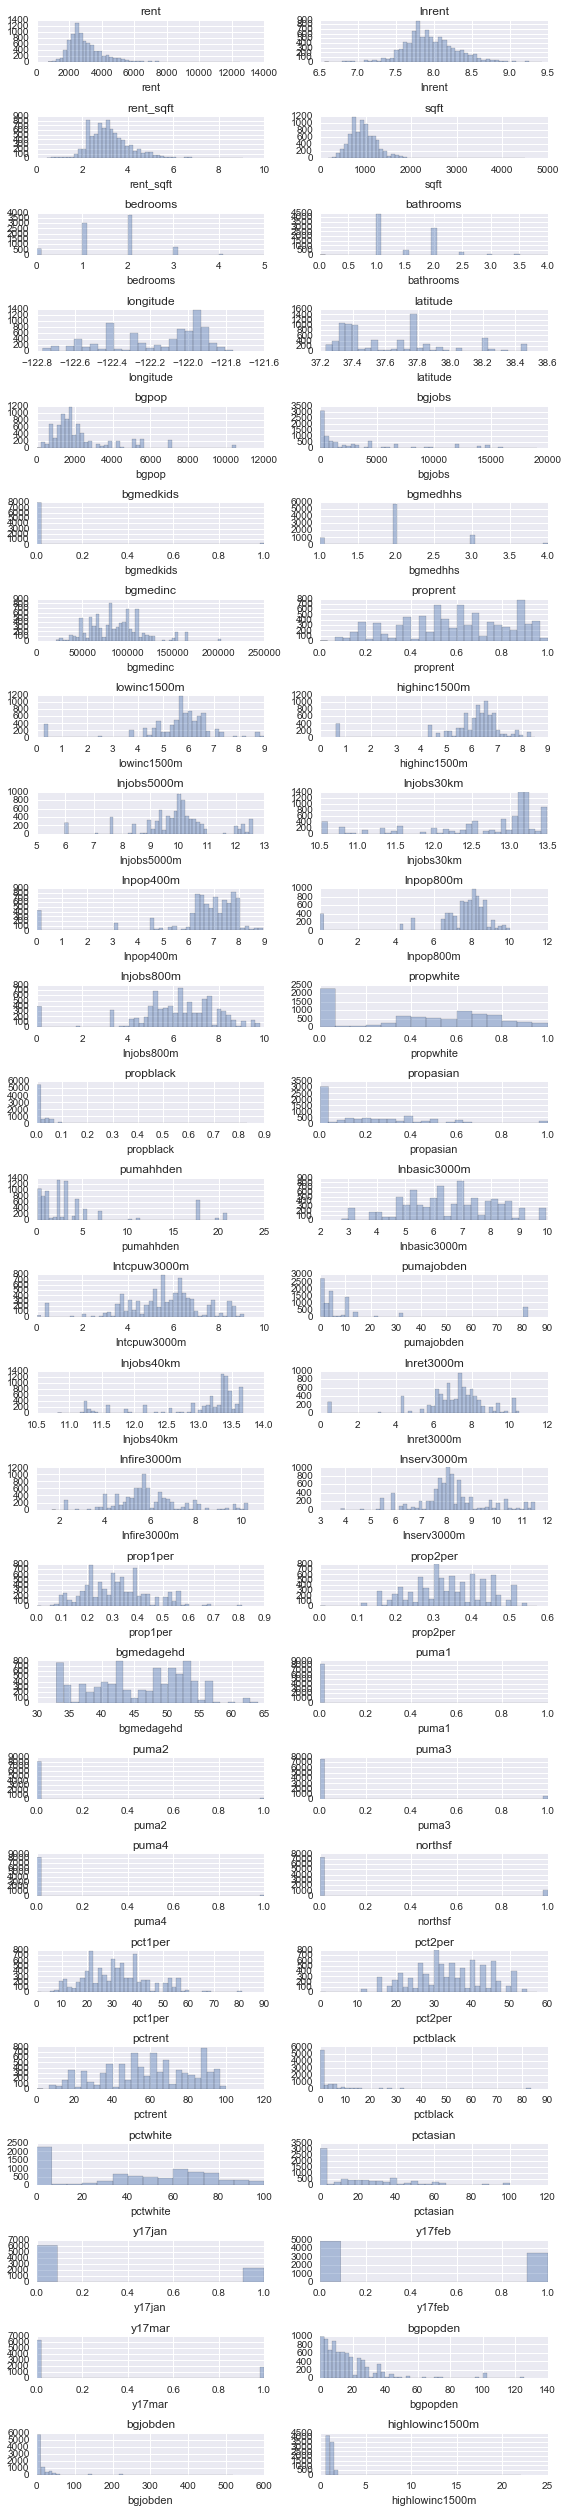

In [223]:
plot_rows = math.ceil(len(cols_to_use)/2)

f, axes = plt.subplots(plot_rows,2, figsize=(8,35))
sns.despine(left=True)

for i,col in enumerate(cols_to_use):
    row_position = math.floor(i/2)
    col_position = i%2
    sns.distplot(df_notnull[col], ax=axes[row_position, col_position],kde=False)
    axes[row_position, col_position].set_title('{}'.format(col)) 

plt.tight_layout()
plt.show()

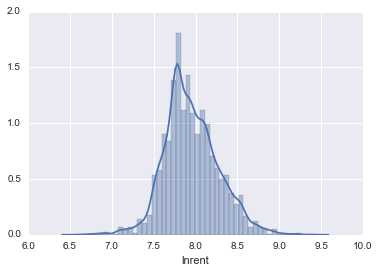

In [224]:
sns.distplot(df['lnrent'])

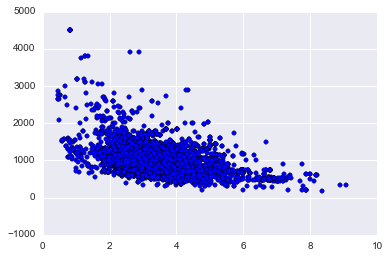

In [225]:
# $/sqft as a function of sqft 
plt.scatter(df.rent_sqft, df.sqft)
plt.show()

In [233]:
def bath_var(row):
    """Make bathrooms/bedroom variable. """
    # Avoid 0 in demoninator. When bedrooms = 0, it's probably a studio. so for practical purposes, br=1
    if row['bedrooms']==0:
        br = 1
    else:
        br = row['bedrooms']
    return row['bathrooms']/br

# this improved the linear model but not the GB. 
# add a variable bath_bed (bathrooms per bedroom)
#df['bath_bed'] = df.apply(bath_var, axis=1)
#cols_to_use.append('bath_bed')

# Linear model

In [12]:
from sklearn import linear_model, model_selection

In [235]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[x_cols],df[y_col], test_size = .3, random_state = 201)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [236]:
# Intercept
print('Intercept:', regr.intercept_)

# The coefficients
print('Coefficients:')
pd.Series(regr.coef_, index=x_cols)

Intercept: -162.323776903
Coefficients:


sqft              -0.001159
bedrooms          -0.289884
bathrooms          0.426166
longitude         -1.500819
latitude          -0.653912
bgpop              0.000002
bgjobs            -0.000014
bgmedkids          0.232380
bgmedhhs           0.085330
bgmedinc           0.000004
proprent          -0.000005
lowinc1500m        0.037276
highinc1500m      -0.184063
lnjobs5000m        0.087449
lnjobs30km        -0.589866
lnpop400m         -0.110084
lnpop800m          0.158096
lnjobs800m         0.043927
propwhite          0.000001
propblack         -0.000092
propasian          0.000007
pumahhden         -0.011631
lnbasic3000m      -0.001249
lntcpuw3000m      -0.039668
pumajobden        -0.007785
lnjobs40km         1.190256
lnret3000m        -0.027932
lnfire3000m       -0.100814
lnserv3000m        0.022887
prop1per           0.000136
prop2per           0.000043
bgmedagehd        -0.014394
puma1             -0.263100
puma2              0.584169
puma3              0.617579
puma4              0

In [237]:
# See mean square error, using test data
print("Mean squared error: %.2f" % np.mean((regr.predict(X_test) - y_test) ** 2))
print("RMSE:", np.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction. 
print('Variance score: %.2f' % regr.score(X_test, y_test))



Mean squared error: 0.31
RMSE: 0.559876928818
Variance score: 0.70


Scores for full dataset w/o bathrooms feature
- Mean squared error: 0.03
- RMSE: 0.186277629605
- Variance score: 0.68


Scores w/ bathrooms feature, dropping missing values - slightly better

- Mean squared error: 0.03
- RMSE: 0.181372180936
- Variance score: 0.69


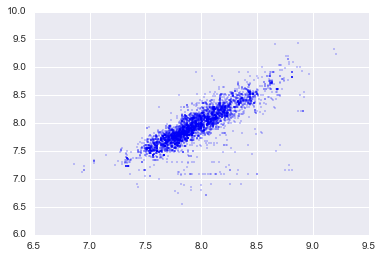

In [16]:
# Plot predicted values vs. observed
plt.scatter(regr.predict(X_train),y_train, color='blue',s=1, alpha=.5)
plt.show()

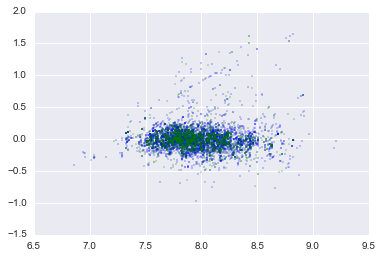

In [17]:
# plot residuals vs predicted values
plt.scatter(regr.predict(X_train), regr.predict(X_train)- y_train, color='blue',s=1, alpha=.5)
plt.scatter(regr.predict(X_test), regr.predict(X_test)- y_test, color='green',s=1, alpha=.5)
plt.show()

In [18]:
print("Training set. Mean squared error: %.5f" % np.mean((regr.predict(X_train) - y_train) ** 2), '| Variance score: %.5f' % regr.score(X_train, y_train))
print("Test set. Mean squared error: %.5f" % np.mean((regr.predict(X_test) - y_test) ** 2), '| Variance score: %.5f' % regr.score(X_test, y_test))

Training set. Mean squared error: 0.03054 | Variance score: 0.70683
Test set. Mean squared error: 0.03290 | Variance score: 0.69352


Does not look like overfitting. (If there were, we'd probably have a smaller error on training set and a larger error on test set.')

# Gradient boosting

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [20]:
def RMSE(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def cross_val_gb(X,y,cv_method='kfold',k=5, **params):
    """Estimate gradient boosting regressor using cross validation.
    
    Args: 
        X (DataFrame): features data
        y (Series): target data
        cv_method (str): how to split the data ('kfold' (default) or 'timeseries')
        k (int): number of folds (default=5)
        **params: keyword arguments for regressor
    Returns: 
        float: mean error (RMSE) across all training/test sets.
    """
    if cv_method == 'kfold':
        kf = KFold(n_splits=k, shuffle=True, random_state=2012016)  # use random seed for reproducibility. 
    
    E = np.ones(k)   # this array will hold the errors. 
    i=0
    for train, test in kf.split(X, y): 
        train_data_x = X.iloc[train]
        train_data_y = y.iloc[train]    
        test_data_x = X.iloc[test]
        test_data_y = y.iloc[test]

        # n_estimators is number of trees to build. 
        grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
        grad_boost.fit(train_data_x,train_data_y)
        predict_y=grad_boost.predict(test_data_x)
        E[i] = RMSE(test_data_y, predict_y)
        i+=1
    return np.mean(E)


In [21]:
df_X = df[x_cols]
df_y = df[y_col]

In [22]:
params = {'n_estimators':100,
          'learning_rate':0.1,
          'max_depth':1,
          'min_samples_leaf':4
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params)

0.17768555628211924

In [193]:

param_grid = {'learning_rate':[.5 ,.1, .05],
              'max_depth':[2,4,6,12],
              'min_samples_leaf': [5,9,17],
              'max_features': [1, .3, .1]
              }

est= GradientBoostingRegressor(n_estimators = 500)
gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

In [194]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'max_depth': 2, 'learning_rate': 0.05, 'min_samples_leaf': 17, 'max_features': 0.3}
0.612986032534


In [189]:
param_grid = {'learning_rate':[5,.2,.1],
              'max_depth':[6,8,12],
              'min_samples_leaf': [17,25],
              'max_features': [.3]
              }

#est= GradientBoostingRegressor(n_estimators = 100)
#gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

In [99]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'max_depth': 12, 'learning_rate': 0.1, 'min_samples_leaf': 17, 'max_features': 0.3}
0.539942208017


In [196]:
# best parameters
params = {'n_estimators':500,
          'learning_rate':0.1,
          'max_depth':4,
          'min_samples_leaf':9,
          'max_features':.3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params, k=3)

0.13212563068130101

Best RMSE when using no bathrooms: 0.1308920

Best RMSE with bathrooms feature: 0.132212

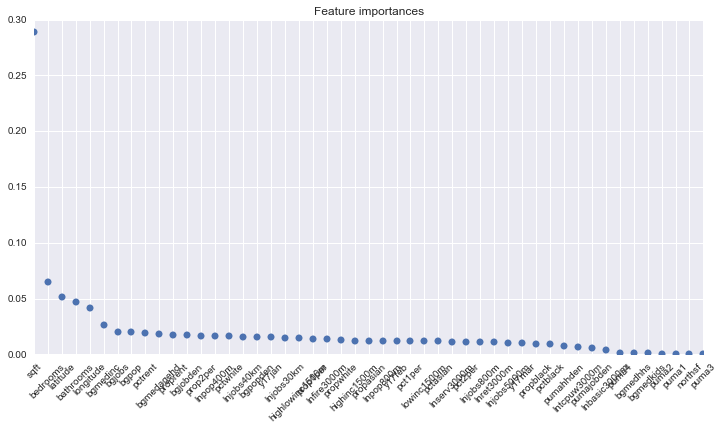

In [197]:
# plot the importances
gb_o = pd.DataFrame({'features':x_cols,'importance':grad_boost.feature_importances_})
gb_o= gb_o.sort_values(by='importance',ascending=False)


plt.figure(1,figsize=(12, 6))
plt.xticks(range(len(gb_o)), gb_o.features,rotation=45)
plt.plot(range(len(gb_o)),gb_o.importance,"o")
plt.title('Feature importances')
plt.show()

In [198]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [23]:
#for i,col in enumerate(df_X.columns): 
#    print(i,col)

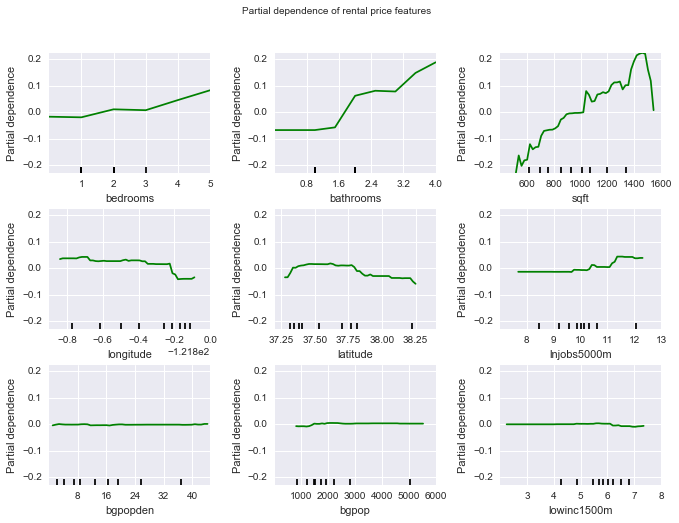

In [202]:
features = [0,1,2,3,4, 13, 46,5,11]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (10,8))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

In [113]:
#TODO: implement partial dependence plots for linear, as comparison


//anaconda/lib/python3.5/site-packages/matplotlib/contour.py:380: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


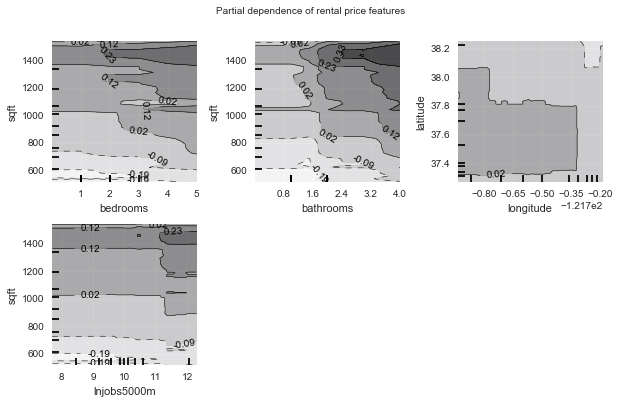

In [204]:
features = [(0,2),(1,2),(3,4),(13,2)]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (9,6))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

## Using $/sqft as target variable

What if we use price per sqft as the y variable? Makes more sense conceptually. 



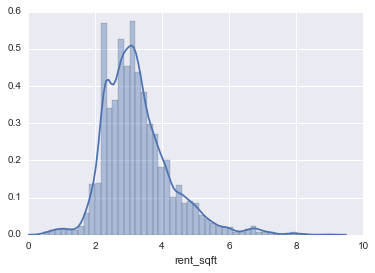

In [238]:
y_col = 'rent_sqft'
df_y = df[y_col]

x_cols = cols_to_use[3:]
df_X = df[x_cols]
sns.distplot(df['rent_sqft'])

Downside is that the distribution is not as normally distributed. It's not that bad though.

### linear with $/sqft as target

In [239]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[x_cols],df[y_col], test_size = .3, random_state = 201)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [240]:
# Intercept
print('Intercept:', regr.intercept_)

# The coefficients
print('Coefficients:')
pd.Series(regr.coef_, index=x_cols)

Intercept: -162.323776903
Coefficients:


sqft              -0.001159
bedrooms          -0.289884
bathrooms          0.426166
longitude         -1.500819
latitude          -0.653912
bgpop              0.000002
bgjobs            -0.000014
bgmedkids          0.232380
bgmedhhs           0.085330
bgmedinc           0.000004
proprent          -0.000005
lowinc1500m        0.037276
highinc1500m      -0.184063
lnjobs5000m        0.087449
lnjobs30km        -0.589866
lnpop400m         -0.110084
lnpop800m          0.158096
lnjobs800m         0.043927
propwhite          0.000001
propblack         -0.000092
propasian          0.000007
pumahhden         -0.011631
lnbasic3000m      -0.001249
lntcpuw3000m      -0.039668
pumajobden        -0.007785
lnjobs40km         1.190256
lnret3000m        -0.027932
lnfire3000m       -0.100814
lnserv3000m        0.022887
prop1per           0.000136
prop2per           0.000043
bgmedagehd        -0.014394
puma1             -0.263100
puma2              0.584169
puma3              0.617579
puma4              0

In [241]:
# See mean square error, using test data
print("Mean squared error: %.2f" % np.mean((regr.predict(X_test) - y_test) ** 2))
print("RMSE:", np.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction. 
print('Variance score: %.2f' % regr.score(X_test, y_test))


Mean squared error: 0.31
RMSE: 0.559876928818
Variance score: 0.70


Since the rent_sqft has a different scale than lnrent, we can't directly compare the RMSE, but we can compare variance score. This variance (0.66) is a bit lower than the linear model before (0.69), which is what we'd expect when we take the most important covariate and put it into the target variable. Still not a bad score here. Not great either, though. 

Added sqft as feature, with rent_sqft still as target: 
- Mean squared error: 0.32
- RMSE: 0.56438373549
- Variance score: 0.69

Added bath/bedrooms feature

- Mean squared error: 0.31
- RMSE: 0.559876928818
- Variance score: 0.70

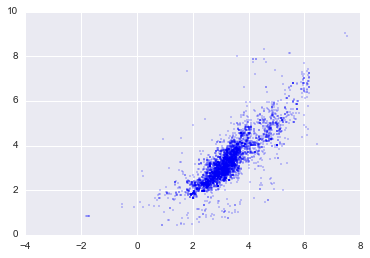

In [242]:
# Plot predicted values vs. observed
plt.scatter(regr.predict(X_train),y_train, color='blue',s=1, alpha=.5)
plt.show()

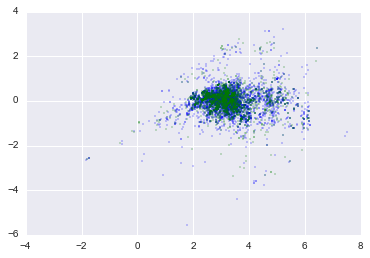

In [243]:
# plot residuals vs predicted values
plt.scatter(regr.predict(X_train), regr.predict(X_train)- y_train, color='blue',s=1, alpha=.5)
plt.scatter(regr.predict(X_test), regr.predict(X_test)- y_test, color='green',s=1, alpha=.5)
plt.show()

In [244]:
print("Training set. Mean squared error: %.5f" % np.mean((regr.predict(X_train) - y_train) ** 2), '| Variance score: %.5f' % regr.score(X_train, y_train))
print("Test set. Mean squared error: %.5f" % np.mean((regr.predict(X_test) - y_test) ** 2), '| Variance score: %.5f' % regr.score(X_test, y_test))

Training set. Mean squared error: 0.28838 | Variance score: 0.70894
Test set. Mean squared error: 0.31346 | Variance score: 0.69741


Might have slight overfitting.

### Gradient boosting with $/sqft as target

In [245]:
params = {'n_estimators':100,
          'learning_rate':0.1,
          'max_depth':1,
          'min_samples_leaf':4
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params)

0.52580919721081787

Without parameter tuning, error is about the same as linear model. RMSE: 0.5947

** Adding sqft as covariate **: RMSE: 0.5258

**Tune the parameters**

In [246]:
param_grid = {'learning_rate':[.5 ,.1, .05],
              'max_depth':[2,4,6,12],
              'min_samples_leaf': [5,9,17],
              'max_features': [1, .3, .1]
              }

est= GradientBoostingRegressor(n_estimators = 500)
gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

In [247]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'max_features': 0.3, 'max_depth': 2, 'min_samples_leaf': 9, 'learning_rate': 0.05}
0.652413203207


In [248]:
# best parameters
params = {'n_estimators':500,
          'learning_rate':0.05,
          'max_depth':2,
          'min_samples_leaf':9,
          'max_features':.3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params, k=3)

0.42268378222019365

In [249]:
# best parameters
params = {'n_estimators':1000,
          'learning_rate':0.05,
          'max_depth':2,
          'min_samples_leaf':9,
          'max_features':.3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params, k=3)

0.40516900635480851

**without sqft as covariate**
RMSE with 500 estimators: 0.4708

RMSE with 1000 estimators: 0.4658

linear model: 0.5965


**with sqft as covariate**
RMSE with 500 estimators: 0.3503

RMSE with 1000 estimators: 0.3508

linear model: 0.5644

** adding bath_bed as feature **

RMSE with 1000 estimators:  0.4051

Why did it get worse? 

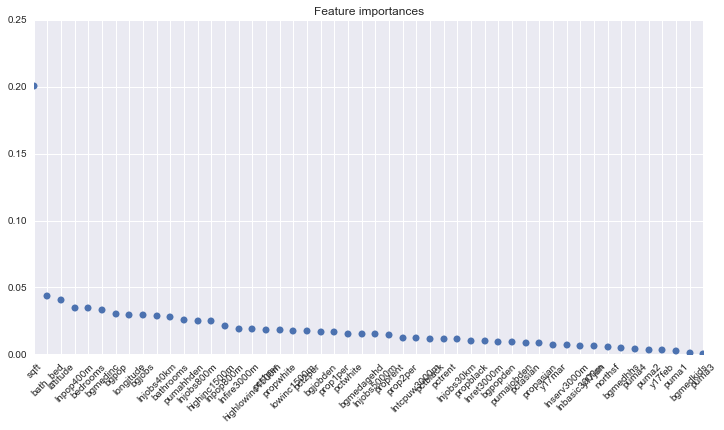

In [250]:
# plot the importances
gb_o = pd.DataFrame({'features':x_cols,'importance':grad_boost.feature_importances_})
gb_o= gb_o.sort_values(by='importance',ascending=False)


plt.figure(1,figsize=(12, 6))
plt.xticks(range(len(gb_o)), gb_o.features,rotation=45)
plt.plot(range(len(gb_o)),gb_o.importance,"o")
plt.title('Feature importances')
plt.show()

In [200]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [253]:
# choose features for partial dependent plots
#for i,col in enumerate(df_X.columns): 
 #   print(i,col)

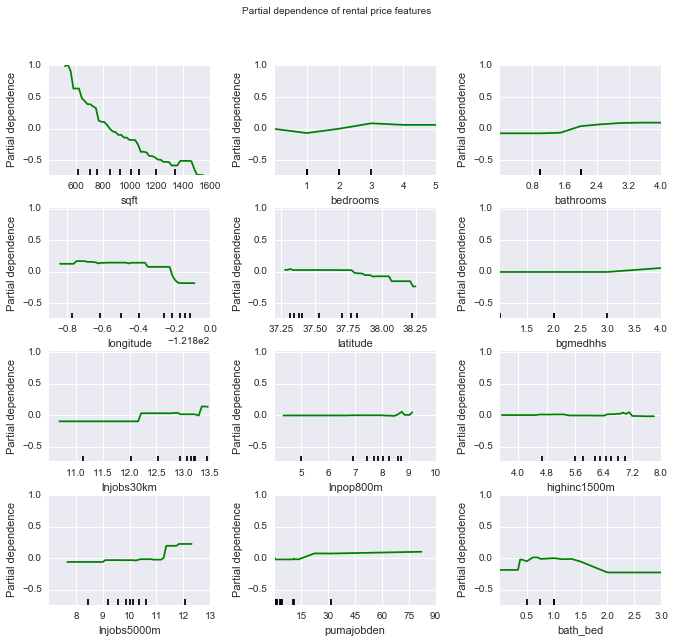

In [254]:
features = [0,1,2,3,4,8,14,16,12,13,24,49]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (10,10))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

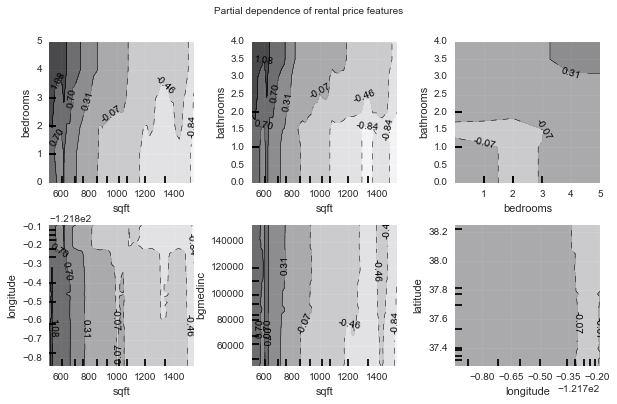

In [204]:
features = [(0,1),(0,2),(1,2),(0,3),(0,9),(3,4)]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (9,6))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

Looks like bathrooms per bedroom might be a good feature to add. Tried this; it made the linear model better but the gradient boosting worse. Maybe because the GB already takes interactiion effects into account.

## Error analysis
- plot errors
- map errors by long/lat

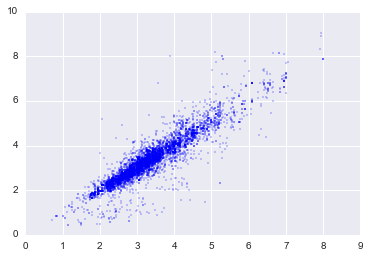

In [255]:
y_pred = grad_boost.predict(df_X)
# plot predicted vs. actual

plt.scatter(y_pred,df_y, color='blue',s=1, alpha=.5)
plt.show()

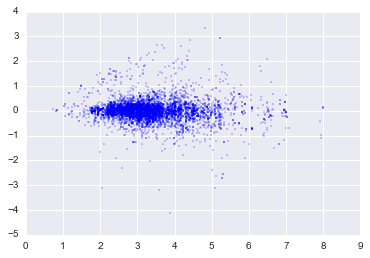

In [256]:
# plot errors vs. predicted
plt.scatter(y_pred, y_pred-df_y, color='blue',s=1,alpha=.5 )
plt.show()

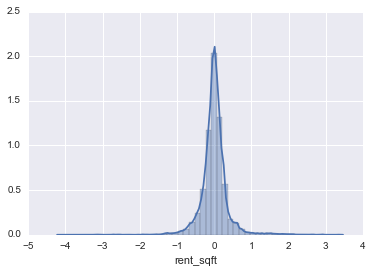

In [257]:
sns.distplot(y_pred-df_y)

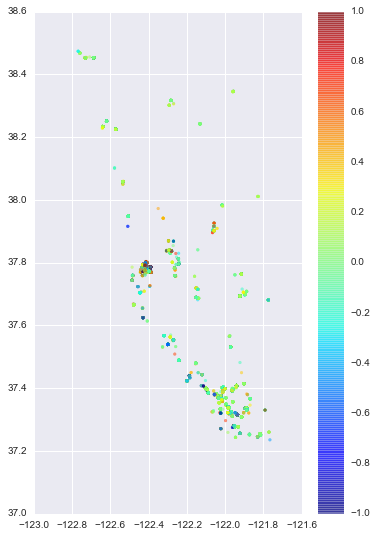

In [260]:
from matplotlib.colors import Normalize
# map the errors. 
x = df_X['longitude']
y = df_X['latitude']
z = y_pred-df_y

norm = Normalize(vmin=-1,vmax=1)  # zoom in on middle of error range

plt.figure(figsize=(6,9))
plt.scatter(x,y, c=z, cmap='jet',s=8,alpha=.5,edgecolors='face', norm=norm)
#plt.xlim(-122.6,-122)
#plt.ylim(37.6,38)
plt.colorbar()
plt.show()

# obs where abs(error)>0.8: 320


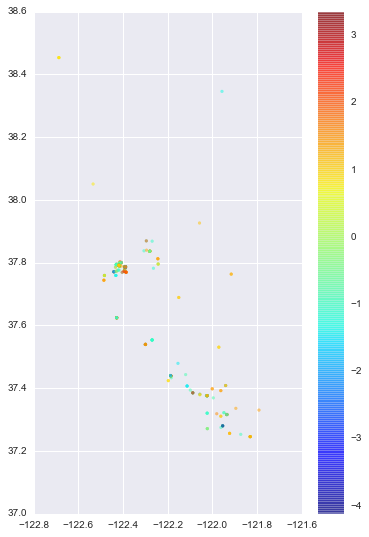

In [261]:
# it's hard to see a pattern in the above, but looks like errors are larger in the central city areas. 
# only show large errors, to make them more clear. 
# map the errors. 

err_cutoff = .8
print('# obs where abs(error)>{}:'.format(err_cutoff),len(z[abs(z)>err_cutoff]))
z_large_err = z[abs(z)>err_cutoff]
x_large_err = x.ix[z_large_err.index,]
y_large_err = y.ix[z_large_err.index,]


plt.figure(figsize=(6,9))
plt.scatter(x_large_err,y_large_err, c=z_large_err, cmap='jet',s=8,alpha=.5,edgecolors='face')

plt.colorbar()
plt.show()

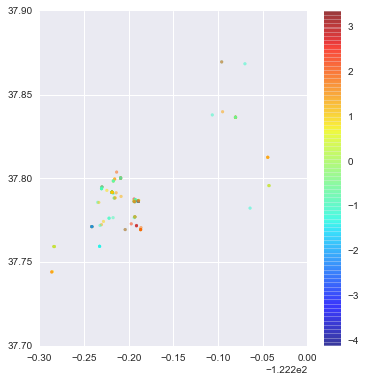

In [262]:
plt.figure(figsize=(6,6))
plt.scatter(x_large_err,y_large_err, c=z_large_err, cmap='jet',s=8,alpha=.5,edgecolors='face')
plt.xlim(-122.5,-122.2)
plt.ylim(37.7,37.9)
plt.colorbar()
plt.show()

I can't find a clear spatial pattern with the errors. Can try with real map... 

